C:\Users\neilt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\neilt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


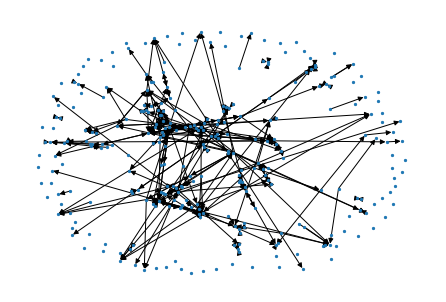

In [1]:
# Import packages
%matplotlib inline
import csv
import networkx as nx

G = nx.DiGraph()

count1=0
count2=0

with open('../data/Drugnet/CSV/DRUGNET.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    header = next(readCSV)
    #print(header)
    for row in readCSV:
        G.add_node(count1)
        count2=0
        for i in range(1, len(row)):
            if row[i]=='1':
                G.add_edge(count1, count2)
            count2+=1
        count1+=1

nx.draw(G, node_size=5)

In [2]:
total = 0
tot_AA = 0
tot_Lat = 0
tot_Whi = 0
tot_M = 0
tot_F = 0
tot_O = 0

with open('../data/Drugnet/CSV/DRUGATTR.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    header = next(readCSV)
    for row in readCSV:
        
        if row[1]=='2':
            G.nodes[total]['ethnicity'] = 'African American'
            tot_AA+=1
        elif row[1]=='3':
            G.nodes[total]['ethnicity'] = 'Latino'
            tot_Lat+=1
        else:
            G.nodes[total]['ethnicity'] = 'white/other'
            tot_Whi+=1
        
        if row[2]=='1':
            G.nodes[total]['gender'] = 'male'
            tot_M+=1
        elif row[2]=='2':
            G.nodes[total]['gender'] = 'female'
            tot_F+=1
        elif row[2]=='0':
            G.nodes[total]['gender'] = 'other/unknown'
            tot_O+=1
        
        total+=1
        
print(total, tot_AA, tot_Lat, tot_Whi, tot_M, tot_F, tot_O)

293 99 155 39 200 86 7


In [3]:
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time

def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.adj[node])) < p
#                 for i in range(len(g.adj[node])):
#                     if success[i]==1:
#                         new_ones.append(list(g.adj[node])[i])
                new_ones += list(np.extract(success, np.array(list(g.adj[node].keys()))))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        #print(np.sort(A))
    return(np.mean(spread))

def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(len(g.nodes()))]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(len(g.nodes())),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes())], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

def IC2(g, S):
    
    A = S[:]
    
    for node in S:
        
        for neighbour in g.adj[node]:
            if neighbour not in A:
                A.append(neighbour)
        
        for predecessor in g.pred[node]:
            if predecessor not in A:
                A.append(predecessor)
                
    return len(A)

def CELF2(g, k):
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC2(g,[node]) for node in range(len(g.nodes()))]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(len(g.nodes())),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes())], [time.time()-start_time]
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC2(g,S+[current]) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)
    

In [4]:
# Run algorithms
celf_output1 = celf(G,20,p=0.5)
celf_output2   = CELF2(G,14)
print("celf output 1:   " + str(celf_output1[0]))
print("celf output 2:   " + str(celf_output2[0]))

celf output 1:   [190, 57, 213, 279, 189, 81, 48, 6, 169, 65, 191, 271, 188, 237, 152, 202, 292, 30, 35, 147]
celf output 2:   [49, 37, 63, 147, 29, 64, 30, 74, 217, 112, 85, 1, 3, 169]


In [5]:
print(celf_output1[1])
print(celf_output2[1])

[21.842, 30.127, 35.628, 40.34, 44.349, 48.187, 51.676, 54.911, 57.813, 60.414, 62.894, 65.193, 67.469, 69.507, 71.545, 73.583, 75.621, 77.643, 79.624, 81.555]
[16, 27, 36, 43, 49, 55, 61, 67, 72, 77, 82, 87, 92, 97]


In [6]:
for node in celf_output1[0]:
    print(G.nodes[node])

print("\n\n")
    
for node in celf_output2[0]:
    print(G.nodes[node])

{'ethnicity': 'African American', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'African American', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'female'}
{'ethnicity': 'African American', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'white/other', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'African American', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'female'}
{'ethnicity': 'African American', 'gender': 'other/unknown'}
{'ethnicity': 'African American', 'gender': 'female'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'female'}
{'ethnicity': 'Latino', 'gender': 'female'}
{'ethnicity': 'African American', 'gender': 'male'}
{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnicity': 'African American', 'gender': 'female'}



{'ethnicity': 'Latino', 'gender': 'male'}
{'ethnici

In [7]:
print("male: ",len([node for node in celf_output1[0] if G.nodes[node]['gender']=='male'])/len(celf_output1[0]))
print("female: ",len([node for node in celf_output1[0] if G.nodes[node]['gender']=='female'])/len(celf_output1[0]))
print("gender unknown: ",len([node for node in celf_output1[0] if G.nodes[node]['gender']=='other/unknown'])/len(celf_output1[0]))
print("Latino: ",len([node for node in celf_output1[0] if G.nodes[node]['ethnicity']=='Latino'])/len(celf_output1[0]))
print("African american: ",len([node for node in celf_output1[0] if G.nodes[node]['ethnicity']=='African American'])/len(celf_output1[0]))
print("white/other: ",len([node for node in celf_output1[0] if G.nodes[node]['ethnicity']=='white/other'])/len(celf_output1[0]))


male:  0.65
female:  0.3
gender unknown:  0.05
Latino:  0.55
African american:  0.4
white/other:  0.05


In [15]:
import scipy.stats

z_male = (0.65-0.68)/np.sqrt(0.68*(1-0.68)/len(G.nodes()))
z_lat = (0.55-0.53)/np.sqrt(0.53*(1-0.53)/len(G.nodes()))
z_aa = (0.4-0.34)/np.sqrt(0.34*(1-0.34)/len(G.nodes()))
z_wo = (0.05-0.13)/np.sqrt(0.13*(1-0.13)/len(G.nodes()))

pv_male = scipy.stats.norm.sf(abs(z_male))*2
pv_lat = scipy.stats.norm.sf(abs(z_lat))*2
pv_aa = scipy.stats.norm.sf(abs(z_aa))*2
pv_wo = scipy.stats.norm.sf(abs(z_wo))*2


print("male: ",pv_male)
print("lat: ",pv_lat)
print("aa: ",pv_aa)
print("wo: ",pv_wo)


male:  0.27096473500179763
lat:  0.4927600954445155
aa:  0.030153234066436576
wo:  4.663985380545463e-05


Total network: 34% AA, 53% Lat, 13% White, 
Celf set: 64% Lat, 36% AA, 0% white
Paper's set: 57% Lat, 29% AA, 14% White/other

For statistics
http://www.stat.yale.edu/Courses/1997-98/101/catinf.htm
https://www.socscistatistics.com/pvalues/tdistribution.aspx

In [8]:
print(celf_output1[1])

[21.842, 30.127, 35.628, 40.34, 44.349, 48.187, 51.676, 54.911, 57.813, 60.414, 62.894, 65.193, 67.469, 69.507, 71.545, 73.583, 75.621, 77.643, 79.624, 81.555]


# print(24 in G.nodes())

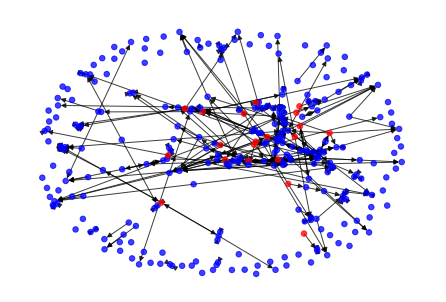

In [9]:
def color(x):
    if x in celf_output1[0]:
        return('red')
    else:
        return('blue')
    
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75, node_size=30)

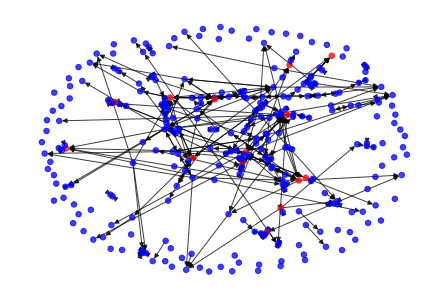

In [10]:
def color(x):
    if x in celf_output2[0]:
        return('red')
    else:
        return('blue')
    
nx.draw(G,node_color=[color(x) for x in G.nodes()],alpha=.75, node_size=30)

In [11]:
pr = nx.pagerank(G)

In [12]:
# 190, 191, 279, 241, 82, 202, 152, 65, 172, 237, 292, 188, 44, 213
pr[279]

0.0010055457257887902

In [13]:
for w in sorted(pr, key=pr.get, reverse=True):
    print(w, pr[w])

28 0.027265855391805007
27 0.024153845177740434
37 0.02016525809399871
74 0.018268679199265656
9 0.0172928614282087
1 0.017161119811396452
102 0.016569834952032375
0 0.016561310848147485
89 0.014579336862744431
243 0.014564416289834164
155 0.014345480359967034
49 0.013716831695605749
236 0.013371708476346942
160 0.01316835770825821
18 0.012551721150208476
17 0.012102647623112249
29 0.011949340596094255
214 0.011256279315947346
42 0.011077842344922748
76 0.010681452098332335
88 0.010574219534279351
30 0.010547605318232555
143 0.010188115359468237
136 0.010086667469298594
117 0.009992971433917372
144 0.00978401252868793
21 0.00966341537827711
85 0.00958377111347181
150 0.009306292167580802
209 0.009114525159953627
36 0.008972476519451439
73 0.008770827615330832
63 0.008697654841084469
162 0.008662678853504713
103 0.008476303426840193
34 0.008241820187424878
54 0.00792307848082732
6 0.007859609146713293
128 0.007697446067883876
33 0.007648063775463806
221 0.007302721547033803
217 0.007286